<a href="https://colab.research.google.com/github/maryofcarmo/ICV/blob/main/PREVIS%C3%83O_DE_CARGA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1° Ligar ao Google e chamar bibliotecas necessárias

In [24]:
# conecta o notebook ao google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
pip install pmdarima

In [14]:
pip install ace_tools

# 2° Ler o arquivo CSV disponibilizado pela ONS

In [42]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/TCC/DADOS/CARGA MENSAL - ONS/CARGA_MENSAL.csv', sep=';')

# Definir a coluna 'din_instante' como datetime e seta como índice

df['din_instante'] = pd.to_datetime(df['din_instante'])
df.set_index('din_instante', inplace=True)

In [77]:
df.dtypes

,0
id_subsistema,object
nom_subsistema,object
val_cargaenergiamwmed,float64


# 3° Limpeza nos dados da ONS

In [43]:
# subsistemas que quero excluir
valores_para_excluir = ['N', 'S', 'SE']

# linha que exclui os subsistemas de fato, deixando só o nordeste
df = df[~df['id_subsistema'].isin(valores_para_excluir)]

#excluindo as colunas id_subsistema	nom_subsistema
colunas_para_remover = ['id_subsistema', 'nom_subsistema']
df = df.drop(columns=colunas_para_remover)

# Exibir a série temporal filtrado
df

,val_cargaenergiamwmed
din_instante,
2000-01-31,5666.025269
2000-02-29,5780.173563
2000-03-31,5839.950538
2000-04-30,5766.368056
2000-05-31,5839.978360
...,...
2024-06-30,12389.525307
2024-07-31,12333.540206
2024-08-31,12662.982818


# 4° gráfico para mostrar a demanda crescente de energia

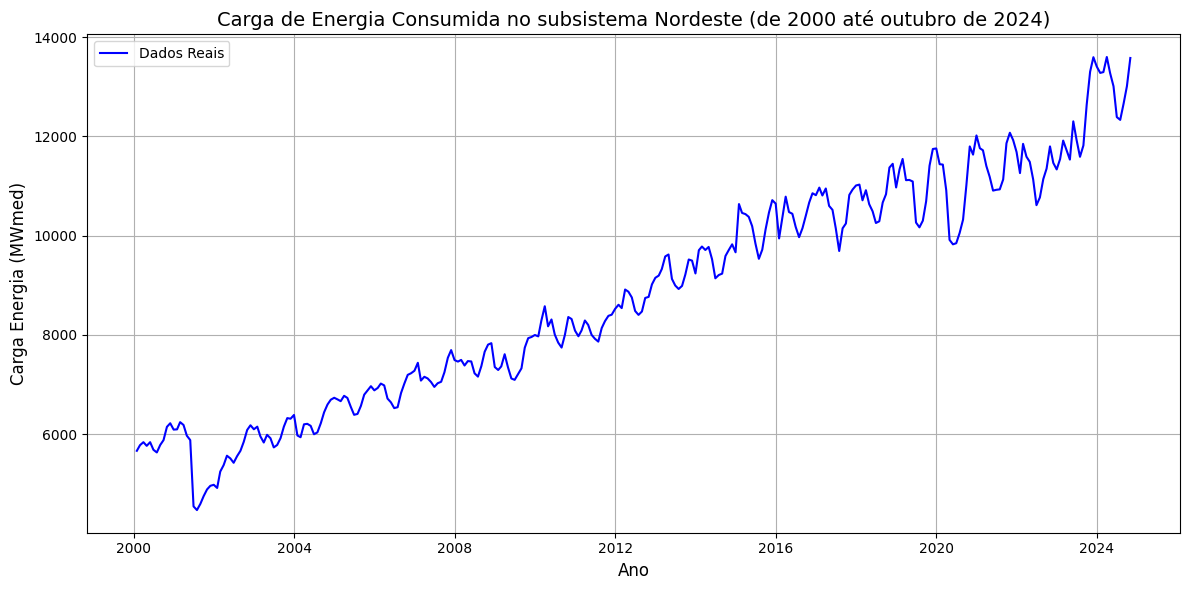

In [44]:
# Criar o gráfico de linha

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['val_cargaenergiamwmed'], label='Dados Reais', color='blue')
plt.title('Carga de Energia Consumida no subsistema Nordeste (de 2000 até outubro de 2024)', fontsize=14)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Carga Energia (MWmed)', fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()

# Exibir o gráfico
plt.show()

# 5° Comparando Modelos de previsão de séries temporais: ARIMA X SARIMA

## MODELO ARIMA

### Código para Otimização dos Parâmetros ARIMA:

In [45]:
#finalidade dessa linha é descobrir os melhores parâmetros (p, d, q) para o método ARIMA

from pmdarima import auto_arima

# Determinar os melhores parâmetros ARIMA
modelo_auto = auto_arima(
    df['val_cargaenergiamwmed'],           # Série temporal
    seasonal=False,        # Defina True se houver sazonalidade
    trace=True,            # Mostra os testes realizados
    suppress_warnings=True, # Suprime avisos
    stepwise=True          # Usa uma busca passo a passo mais rápida
)

# Exibir os parâmetros escolhidos
print("Melhores parâmetros ARIMA:", modelo_auto.order)

# Exibir o resumo do modelo
print(modelo_auto.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4188.146, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4177.785, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4176.794, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4188.876, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4178.865, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4178.774, Time=1.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4176.712, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4178.743, Time=0.38 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4178.710, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4177.603, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4167.762, Time=0.27 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4128.488, Time=0.61 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4

### Implementação do modelo ARIMA

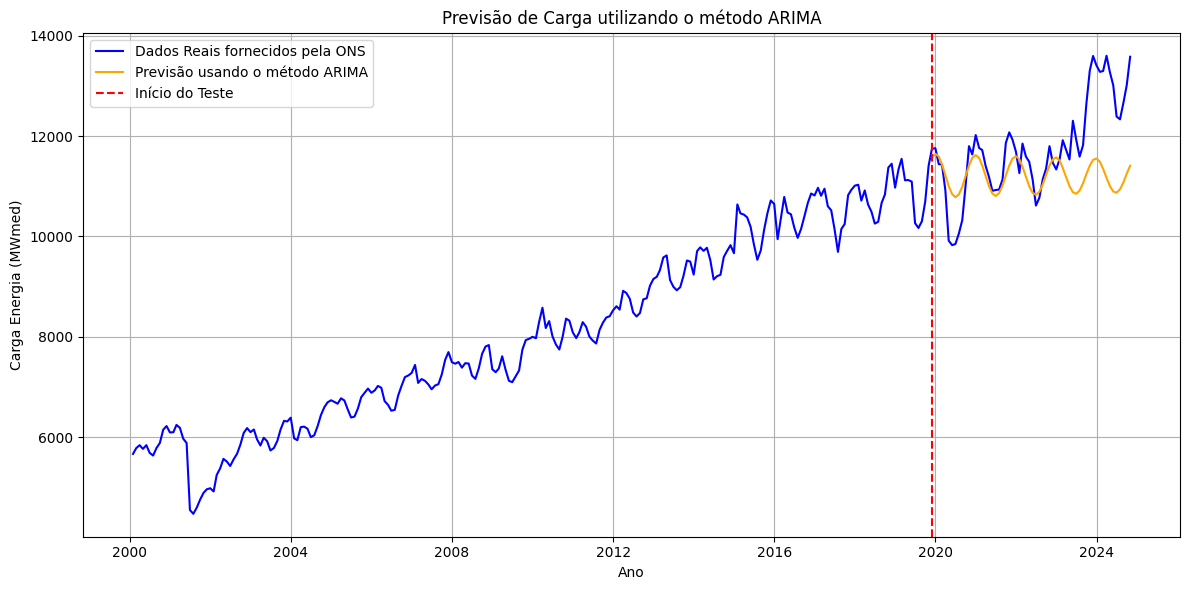

In [48]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Dividir os dados em treino e teste (80% treino, 20% teste)
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

# Ajustar o modelo ARIMA
model = ARIMA(train, order=(2, 1, 2))  # Ajustar os parâmetros (p, d, q)
model_fit = model.fit()

# Fazer previsões
forecast = model_fit.forecast(steps=len(test))

# Plotar resultados
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['val_cargaenergiamwmed'], label='Dados Reais fornecidos pela ONS', color='blue')
plt.plot(test.index, forecast, label='Previsão usando o método ARIMA', color='orange')
plt.axvline(x=test.index[0], color='red', linestyle='--', label='Início do Teste')
plt.title('Previsão de Carga utilizando o método ARIMA')
plt.xlabel('Ano')
plt.ylabel('Carga Energia (MWmed)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## MODELO SARIMA


### Código para Otimização dos Parâmetros SARIMA:

In [11]:
import pandas as pd
from pmdarima import auto_arima
import warnings

# Suprimindo avisos desnecessários
warnings.filterwarnings("ignore")

# Preparando os dados da série temporal
serie = df['val_cargaenergiamwmed']

# Encontrando os melhores parâmetros para SARIMA usando auto_arima
stepwise_model = auto_arima(
    serie,
    seasonal=True,        # Considera a sazonalidade
    m=12,                 # Período sazonal (12 meses para dados mensais)
    trace=True,           # Mostra o progresso da busca
    error_action='ignore',# Ignora erros durante o ajuste
    suppress_warnings=True,
    stepwise=True         # Utiliza busca passo a passo para eficiência
)

# Exibindo os melhores parâmetros encontrados
print("Melhores parâmetros SARIMA:", stepwise_model.order)
print("Melhores parâmetros sazonais SARIMA:", stepwise_model.seasonal_order)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=2.63 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=4188.146, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=4143.159, Time=2.46 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=4155.192, Time=1.41 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=4188.876, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=4177.785, Time=0.07 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=4121.645, Time=2.00 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=4093.963, Time=3.52 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=4090.676, Time=1.33 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=4156.007, Time=0.41 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=4092.623, Time=3.46 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=4142.941, Time=4.15 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=5.50 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=4088.926, Time=0.93 sec
 ARIMA(0,1,0)(0,0,1)[12] inte

### Implementação do modelo SARIMA

                                     SARIMAX Results                                      
Dep. Variable:              val_cargaenergiamwmed   No. Observations:                  238
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -1501.208
Date:                            Fri, 13 Dec 2024   AIC                           3012.415
Time:                                    03:26:09   BIC                           3029.451
Sample:                                01-31-2000   HQIC                          3019.293
                                     - 10-31-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8297      0.042     19.865      0.000       0.748       0.912
ma.L1         -1.0000      0.085   

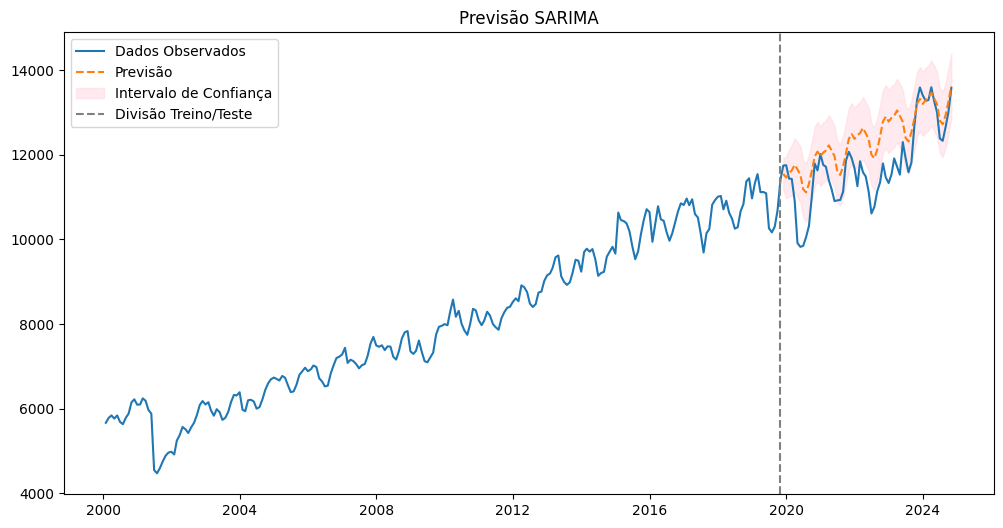

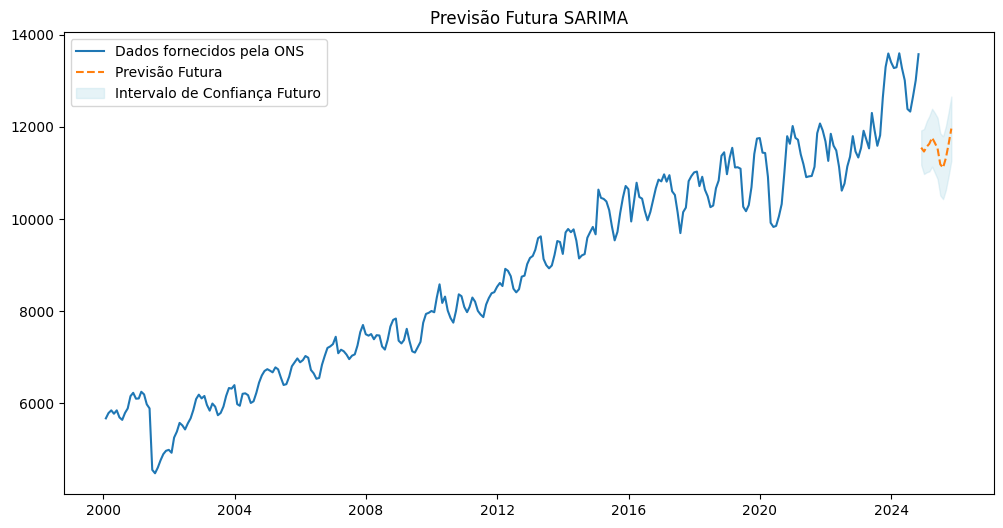

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
import warnings

warnings.filterwarnings("ignore")

# Série temporal
serie = df['val_cargaenergiamwmed']

# Divisão em treino e teste
train_size = int(len(serie) * 0.8)  # 80% para treino, 20% para teste
train, test = serie[:train_size], serie[train_size:]

# Parâmetros escolhidos (você pode ajustar ou usar auto_arima para determinar os melhores)
p, d, q = 1, 1, 1
P, D, Q, s = 1, 0, 1, 12  # Sazonalidade mensal

# Ajustando o modelo SARIMA
model = SARIMAX(
    train,
    order=(p, d, q),
    seasonal_order=(P, D, Q, s),
    enforce_stationarity=False,
    enforce_invertibility=False,
)

sarima_result = model.fit(disp=False)

# Resumo do modelo
print(sarima_result.summary())

# Previsão
forecast_steps = len(test)  # Previsões para o mesmo número de observações do conjunto de teste
forecast = sarima_result.get_forecast(steps=forecast_steps)
forecast_index = test.index

# Intervalos de confiança
conf_int = forecast.conf_int()

# Calculando o erro
forecast_values = forecast.predicted_mean
mae = mean_absolute_error(test, forecast_values)
print(f"Erro Médio Absoluto (MAE): {mae:.2f}")

# Visualizando os resultados
plt.figure(figsize=(12, 6))
plt.plot(serie, label='Dados Observados')
plt.plot(forecast_index, forecast_values, label='Previsão', linestyle='--')
plt.fill_between(
    forecast_index,
    conf_int.iloc[:, 0],
    conf_int.iloc[:, 1],
    color='pink',
    alpha=0.3,
    label='Intervalo de Confiança',
)
plt.axvline(x=train.index[-1], color='gray', linestyle='--', label='Divisão Treino/Teste')
plt.legend()
plt.title('Previsão SARIMA')
plt.show()

# Previsões futuras (extrapolando além dos dados conhecidos)
future_steps = 12  # Previsão para os próximos 12 meses
future_forecast = sarima_result.get_forecast(steps=future_steps)
future_index = pd.date_range(start=serie.index[-1] + pd.DateOffset(1), periods=future_steps, freq='M')
future_values = future_forecast.predicted_mean
future_conf_int = future_forecast.conf_int()

# Visualizar previsões futuras
plt.figure(figsize=(12, 6))
plt.plot(serie, label='Dados fornecidos pela ONS')
plt.plot(future_index, future_values, label='Previsão Futura', linestyle='--')
plt.fill_between(
    future_index,
    future_conf_int.iloc[:, 0],
    future_conf_int.iloc[:, 1],
    color='lightblue',
    alpha=0.3,
    label='Intervalo de Confiança Futuro',
)
plt.legend()
plt.title('Previsão Futura SARIMA')
plt.show()


# 6° Previsão de carga no subsistema Nordeste com o metodo SARIMA, para um futuro de 5 anos pra frente

E: Unable to locate package ace_tools
                                     SARIMAX Results                                      
Dep. Variable:              val_cargaenergiamwmed   No. Observations:                  298
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -1941.109
Date:                            Fri, 13 Dec 2024   AIC                           3892.218
Time:                                    03:25:36   BIC                           3910.445
Sample:                                01-31-2000   HQIC                          3899.526
                                     - 10-31-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8663      0.040     21.763      0.000       0.788       0.9

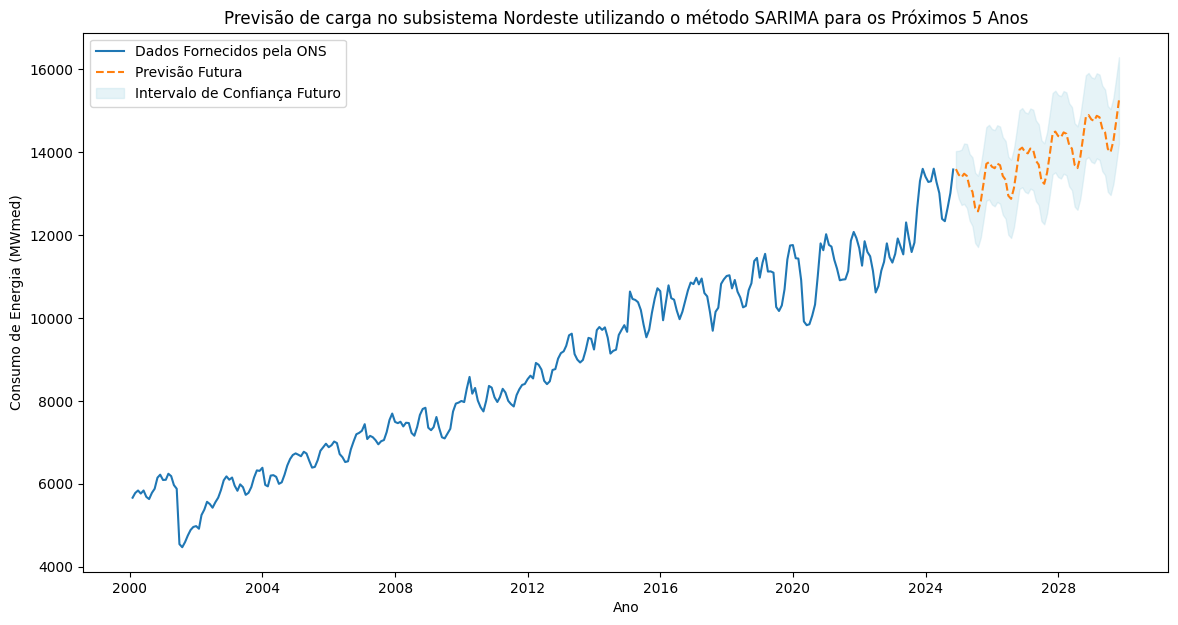

ModuleNotFoundError: No module named 'ace_tools'

In [20]:
!apt-get -qq install -y ace_tools # Install the missing 'ace_tools' package.

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

warnings.filterwarnings("ignore")

# Série temporal
serie = df['val_cargaenergiamwmed']

# Parâmetros do SARIMA (ajuste conforme necessário ou use auto_arima para determinar os melhores parâmetros)
p, d, q = 1, 1, 1
P, D, Q, s = 1, 0, 1, 12  # Sazonalidade mensal

# Ajustando o modelo SARIMA
model = SARIMAX(
    serie,
    order=(p, d, q),
    seasonal_order=(P, D, Q, s),
    enforce_stationarity=False,
    enforce_invertibility=False,
)

sarima_result = model.fit(disp=False)

# Resumo do modelo
print(sarima_result.summary())

# Previsões para os próximos 5 anos (60 meses)
future_steps = 60
future_forecast = sarima_result.get_forecast(steps=future_steps)
future_index = pd.date_range(start=serie.index[-1] + pd.DateOffset(1), periods=future_steps, freq='M')
future_values = future_forecast.predicted_mean
future_conf_int = future_forecast.conf_int()

# Visualizando os resultados
plt.figure(figsize=(14, 7))
plt.plot(serie, label='Dados Fornecidos pela ONS')
plt.plot(future_index, future_values, label='Previsão Futura', linestyle='--')
plt.fill_between(
    future_index,
    future_conf_int.iloc[:, 0],
    future_conf_int.iloc[:, 1],
    color='lightblue',
    alpha=0.3,
    label='Intervalo de Confiança Futuro',
)
plt.legend()
plt.title('Previsão de carga no subsistema Nordeste utilizando o método SARIMA para os Próximos 5 Anos')
plt.xlabel('Ano')
plt.ylabel('Consumo de Energia (MWmed)')
plt.show()

# Exibindo os valores previstos em formato de DataFrame
future_df = pd.DataFrame({
    'Data': future_index,
    'Previsão': future_values,
    'Limite Inferior': future_conf_int.iloc[:, 0],
    'Limite Superior': future_conf_int.iloc[:, 1],
})
future_df.set_index('Data', inplace=True)

# Mostrar os valores previstos
import ace_tools as tools; tools.display_dataframe_to_user(name="Previsão para os próximos 5 anos", dataframe=future_df)
